## Adapted from Victor Zhou's CNN published at [this blog post](https://victorzhou.com/blog/keras-cnn-tutorial/).

In [1]:
import math
import mnist
import numpy as np

# Using tf.keras for Ghost Batch Norm capability.
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Nadam

import tensorflow as tf
#print(tf.version)
# Disable INFO and WARNING messages from TensorFlow.
# Our Keras version (2.2.4 / TF 1.15.0) throws deprecation warnings.
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
train_images = mnist.train_images() 
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

num_filters = 8
filter_size = 3
pool_size = 2

In [3]:
# Build the model.
batch_size = 100       # TODO: make this less arbitrary.
ghost_batch_size = 10  # TODO: make this less arbitrary.

model = Sequential([
    # The authors required ghost batch normalization in their experiments.
    # The papers they reference use normalization preceding each convolutional layer.
    BatchNormalization(virtual_batch_size=ghost_batch_size),
    Conv2D(filters=num_filters, kernel_size=filter_size, input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(units=10, activation='softmax'),
])

In [4]:
# Adapted from https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def step_lr_decay(epoch):
    # This starts with a learning rate higher than the default learning rate in
    # Vanilla SGD. It drops by a factor of 5 each step, and I chose to drop after
    # every other epoch to make training not take too long on a laptop.
    # Think of this as a half-life equation.
    initial_lrate=0.15
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate

In [5]:
# Compile the model.
epochs = 6            # Run enough epochs to test the training schedule.
learning_rate = 0.00  # Will be overrided by the scheduler.
decay_rate = 0.00     # Default decay rate.
momentum = 0.0        # Default momentum.

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

## Experiment 1: Vanilla SGD, decaying learning rate.

In [6]:
# Train the model.
decay_lr_scheduler = LearningRateScheduler(step_lr_decay)

exp1_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[decay_lr_scheduler]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.150000
Epoch 1/6
60000/60000 [==============================] - 6s 94us/sample - loss: 0.2313 - acc: 0.9315 - val_loss: 0.1098 - val_acc: 0.9657
Epoch 2 learning rate: 0.150000
Epoch 2/6
60000/60000 [==============================] - 8s 129us/sample - loss: 0.1088 - acc: 0.9676 - val_loss: 0.0903 - val_acc: 0.9713
Epoch 3 learning rate: 0.030000
Epoch 3/6
60000/60000 [==============================] - 8s 137us/sample - loss: 0.0669 - acc: 0.9808 - val_loss: 0.0715 - val_acc: 0.9768
Epoch 4 learning rate: 0.030000
Epoch 4/6
60000/60000 [==============================] - 8s 140us/sample - loss: 0.0610 - acc: 0.9825 - val_loss: 0.0690 - val_acc: 0.9782
Epoch 5 learning rate: 0.006000
Epoch 5/6
60000/60000 [==============================] - 8s 136us/sample - loss: 0.0540 - acc: 0.9847 - val_loss: 0.0676 - val_acc: 0.9794
Epoch 6 learning rate: 0.006000
Epoch 6/6
60000/60000 [==============================] - 8s 134u

In [7]:
exp1_results.history

{'loss': [0.23133539444456497,
  0.1087887740538766,
  0.06690199436154216,
  0.06102695704903453,
  0.053963111427923045,
  0.05299553099088371],
 'acc': [0.93151665, 0.96765, 0.98078334, 0.98245, 0.98468333, 0.98515],
 'val_loss': [0.10980322206392884,
  0.09032940616831184,
  0.07148506407625974,
  0.06902221580501645,
  0.06756993195042015,
  0.06698918364010752],
 'val_acc': [0.9657, 0.9713, 0.9768, 0.9782, 0.9794, 0.9788],
 'lr': [0.15, 0.15, 0.03, 0.03, 0.006, 0.006]}

## Experiment 2: Vanilla SGD, increasing batch size.

In [8]:
# Keras has no built in for this. 
# Code is from https://www.codementor.io/nitinsurya/how-to-re-initialize-keras-model-weights-et41zre2g
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [9]:
reset_weights(model)
learning_rate = 0.07  # Set a new constant.
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Just run each step independently. Keras has no callback for this.
exp2_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels))
)
tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels))
)

for i in tmp_results.history.keys():
    exp2_results.history[i].extend(tmp_results.history[i])

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 25,
    validation_data=(test_images, to_categorical(test_labels))
)

for i in tmp_results.history.keys():
    exp2_results.history[i].extend(tmp_results.history[i])


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 8s 134us/sample - loss: 0.2583 - acc: 0.9212 - val_loss: 0.1501 - val_acc: 0.9504
Epoch 2/2
60000/60000 [==============================] - 8s 138us/sample - loss: 0.1285 - acc: 0.9616 - val_loss: 0.0972 - val_acc: 0.9687
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 122us/sample - loss: 0.0906 - acc: 0.9734 - val_loss: 0.0845 - val_acc: 0.9728
Epoch 2/2
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0835 - acc: 0.9750 - val_loss: 0.0798 - val_acc: 0.9740
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 110us/sample - loss: 0.0772 - acc: 0.9773 - val_loss: 0.0790 - val_acc: 0.9737
Epoch 2/2
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0756 - acc: 0.9782 - val_loss: 0.0784 - val_acc: 0.9740


In [10]:
exp2_results.history

{'loss': [0.2583177598255376,
  0.1284704947657883,
  0.09055903333549699,
  0.0835349808447063,
  0.07723505624259512,
  0.07559128726522128],
 'acc': [0.92116666, 0.9616333, 0.9734, 0.97495, 0.97728336, 0.97815],
 'val_loss': [0.15013285676017404,
  0.09717871752567589,
  0.08447987865656614,
  0.07984034046530723,
  0.07899953238666058,
  0.07840237021446228],
 'val_acc': [0.9504, 0.9687, 0.9728, 0.974, 0.9737, 0.974]}

## Experiment 3: Vanilla SGD, hybrid.

In [11]:
def hybrid_lr_decay(epoch):
    # Start off from the constant learning rate from the hybrid's initialization.
    initial_lrate=0.05
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate

hybrid_lr_scheduler = LearningRateScheduler(hybrid_lr_decay)

In [12]:
reset_weights(model)
learning_rate = 0.05  # Set a new constant.
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Run a step, and then increase the batch size manually. The decay scheduler
# will decay the learning rate in the next step.
exp3_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels))
)

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=4,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[hybrid_lr_scheduler]
)

for i in tmp_results.history.keys():
    if i == 'lr':
        continue
    exp3_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 8s 135us/sample - loss: 0.2792 - acc: 0.9182 - val_loss: 0.1581 - val_acc: 0.9536
Epoch 2/2
60000/60000 [==============================] - 9s 142us/sample - loss: 0.1446 - acc: 0.9569 - val_loss: 0.1263 - val_acc: 0.9618
Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.050000
Epoch 1/4
60000/60000 [==============================] - 8s 131us/sample - loss: 0.1038 - acc: 0.9705 - val_loss: 0.1054 - val_acc: 0.9696
Epoch 2 learning rate: 0.050000
Epoch 2/4
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0968 - acc: 0.9722 - val_loss: 0.1020 - val_acc: 0.9697
Epoch 3 learning rate: 0.010000
Epoch 3/4
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0900 - acc: 0.9743 - val_loss: 0.1000 - val_acc: 0.9704
Epoch 4 learning rate: 0.010000
Epoch 4/4
60000/60000 [==============================] - 7s 125us/sample - lo

In [13]:
exp3_results.history

{'loss': [0.27916646376252174,
  0.144623649045825,
  0.10382130329186717,
  0.09681988762070735,
  0.08997332798317074,
  0.08866024520248175],
 'acc': [0.91823334, 0.9568667, 0.9705167, 0.97223336, 0.97433335, 0.9748167],
 'val_loss': [0.15805390674620867,
  0.12629101648926735,
  0.10537823718041181,
  0.10200611315667629,
  0.10002062730491161,
  0.09980837162584066],
 'val_acc': [0.9536, 0.9618, 0.9696, 0.9697, 0.9704, 0.9705]}

## Experiment 4: Adam, decaying learning rate

In [14]:
'''
# Adapted from https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def step_lr_decay_adam(epoch):
    # Same learning-rate decaying algorithm as Vanilla SGD, except setting the initial rate to 0.001
    initial_lrate=0.001
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate
'''
reset_weights(model)
nadam = Nadam() #The paper uses the default settings for Adam

model.compile(
    optimizer=nadam,  # Adam experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Train the model.
decay_lr_scheduler = LearningRateScheduler(step_lr_decay)

exp4_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[decay_lr_scheduler]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.150000
Epoch 1/6
60000/60000 [==============================] - 8s 138us/sample - loss: 1.1778 - acc: 0.9183 - val_loss: 0.1291 - val_acc: 0.9607
Epoch 2 learning rate: 0.150000
Epoch 2/6
60000/60000 [==============================] - 8s 140us/sample - loss: 0.1322 - acc: 0.9603 - val_loss: 0.1091 - val_acc: 0.9657
Epoch 3 learning rate: 0.030000
Epoch 3/6
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0720 - acc: 0.9790 - val_loss: 0.0814 - val_acc: 0.9738cc: 0.9
Epoch 4 learning rate: 0.030000
Epoch 4/6
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0659 - acc: 0.9806 - val_loss: 0.0817 - val_acc: 0.9735
Epoch 5 learning rate: 0.006000
Epoch 5/6
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0492 - acc: 0.9851 - val_loss: 0.0767 - val_acc: 0.9769
Epoch 6 learning rate: 0.006000
Epoch 6/6
60000/60000 [==============================] -

In [15]:
exp4_results.history

{'loss': [1.1778050466813148,
  0.13217506480403243,
  0.07196073113474995,
  0.06590718468884006,
  0.0492229970660992,
  0.04634817166874806],
 'acc': [0.91835, 0.96025, 0.979, 0.9805833, 0.98511666, 0.9863167],
 'val_loss': [0.12910960301756857,
  0.10913823520764708,
  0.08136494354810565,
  0.08170081057585776,
  0.07671990296803415,
  0.07571628901176154],
 'val_acc': [0.9607, 0.9657, 0.9738, 0.9735, 0.9769, 0.9773],
 'lr': [0.15, 0.15, 0.03, 0.03, 0.006, 0.006]}

## Experiment 5: Adam, increasing batch size.

In [16]:
reset_weights(model)
nadam = Nadam() #The paper uses the default settings for Adam

model.compile(
    optimizer=nadam,  # Adam experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Just run each step independently. Keras has no callback for this.
exp5_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels))
)
tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels))
)

for i in tmp_results.history.keys():
    exp5_results.history[i].extend(tmp_results.history[i])

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 25,
    validation_data=(test_images, to_categorical(test_labels))
)

for i in tmp_results.history.keys():
    exp5_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 96us/sample - loss: 0.5131 - acc: 0.8641 - val_loss: 0.2429 - val_acc: 0.9281
Epoch 2/2
60000/60000 [==============================] - 6s 99us/sample - loss: 0.2061 - acc: 0.9408 - val_loss: 0.1536 - val_acc: 0.9556
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 88us/sample - loss: 0.1484 - acc: 0.9581 - val_loss: 0.1360 - val_acc: 0.9612
Epoch 2/2
60000/60000 [==============================] - 5s 88us/sample - loss: 0.1350 - acc: 0.9619 - val_loss: 0.1249 - val_acc: 0.9642
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 79us/sample - loss: 0.1254 - acc: 0.9648 - val_loss: 0.1223 - val_acc: 0.9647
Epoch 2/2
60000/60000 [==============================] - 5s 81us/sample - loss: 0.1231 - acc: 0.9656 - val_loss: 0.1206 - val_acc: 0.9658


In [17]:
exp5_results.history

{'loss': [0.513140340608855,
  0.2061198809494575,
  0.1484100411956509,
  0.13497188227872053,
  0.1253632806862394,
  0.12308977792660396],
 'acc': [0.86415, 0.94081664, 0.95805, 0.9619167, 0.9647833, 0.96563333],
 'val_loss': [0.24285398706793784,
  0.1536485778540373,
  0.1360220957547426,
  0.12486526258289814,
  0.12232028134167194,
  0.12062463536858559],
 'val_acc': [0.9281, 0.9556, 0.9612, 0.9642, 0.9647, 0.9658]}

## Experiment 6: Adam, hybrid.

In [18]:
def hybrid_lr_decay_adam(epoch):
    # Start off from the constant learning rate from the hybrid's initialization.
    initial_lrate=0.001 #initial learning rate for Adam's Keras's default = 0.001
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate

hybrid_lr_scheduler_adam = LearningRateScheduler(hybrid_lr_decay_adam)

In [19]:
reset_weights(model)
nadam = Nadam() #The paper uses the default settings for Adam

model.compile(
    optimizer=nadam,  # Adam experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Run a step, and then increase the batch size manually. The decay scheduler
# will decay the learning rate in the next step.
exp6_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels))
)
tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=4,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[hybrid_lr_scheduler_adam]
)

for i in tmp_results.history.keys():
    if i == 'lr':
        continue
    exp6_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 108us/sample - loss: 0.4142 - acc: 0.8851 - val_loss: 0.2215 - val_acc: 0.9389
Epoch 2/2
60000/60000 [==============================] - 6s 102us/sample - loss: 0.1861 - acc: 0.9473 - val_loss: 0.1451 - val_acc: 0.9580
Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.001000
Epoch 1/4
60000/60000 [==============================] - 8s 133us/sample - loss: 0.1342 - acc: 0.9628 - val_loss: 0.1301 - val_acc: 0.9635
Epoch 2 learning rate: 0.001000
Epoch 2/4
60000/60000 [==============================] - 7s 114us/sample - loss: 0.1230 - acc: 0.9656 - val_loss: 0.1226 - val_acc: 0.9651
Epoch 3 learning rate: 0.000200
Epoch 3/4
60000/60000 [==============================] - 7s 115us/sample - loss: 0.1146 - acc: 0.9689 - val_loss: 0.1207 - val_acc: 0.9660
Epoch 4 learning rate: 0.000200
Epoch 4/4
60000/60000 [==============================] - 7s 114us/sample - lo

In [20]:
exp6_results.history

{'loss': [0.41419782443592945,
  0.18614247323945166,
  0.1341808730736375,
  0.12300668253252904,
  0.11459468708684047,
  0.11243555704131722],
 'acc': [0.8850833, 0.94725, 0.9628, 0.96563333, 0.96893334, 0.9690833],
 'val_loss': [0.22146016359329224,
  0.1451292433962226,
  0.13013552501797676,
  0.12260526977479458,
  0.12067335024476052,
  0.11885160058736802],
 'val_acc': [0.9389, 0.958, 0.9635, 0.9651, 0.966, 0.9661]}

## Experiment 7: SGD with momentum, decaying learning rate.

In [21]:
reset_weights(model)
learning_rate = 0.07  # Set a new constant.
momentum = 0.1
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Train the model.
decay_lr_scheduler = LearningRateScheduler(step_lr_decay)

exp7_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[decay_lr_scheduler]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.150000
Epoch 1/6
60000/60000 [==============================] - 8s 127us/sample - loss: nan - acc: 0.0997 - val_loss: nan - val_acc: 0.0980
Epoch 2 learning rate: 0.150000
Epoch 2/6
60000/60000 [==============================] - 8s 126us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 3 learning rate: 0.030000
Epoch 3/6
60000/60000 [==============================] - 7s 122us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 4 learning rate: 0.030000
Epoch 4/6
60000/60000 [==============================] - 7s 125us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 5 learning rate: 0.006000
Epoch 5/6
60000/60000 [==============================] - 7s 117us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 6 learning rate: 0.006000
Epoch 6/6
60000/60000 [==============================] - 7s 124us/sample - loss: nan - acc: 0

In [22]:
exp7_results.history

{'loss': [nan, nan, nan, nan, nan, nan],
 'acc': [0.09966667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667],
 'val_loss': [nan, nan, nan, nan, nan, nan],
 'val_acc': [0.098, 0.098, 0.098, 0.098, 0.098, 0.098],
 'lr': [0.15, 0.15, 0.03, 0.03, 0.006, 0.006]}

## Experiment 8: SGD with momentum, increasing batch size.

In [23]:
reset_weights(model)
momentum = 0.1
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Just run each step independently. Keras has no callback for this.
exp8_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels))
)
tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels))
)

for i in tmp_results.history.keys():
    exp8_results.history[i].extend(tmp_results.history[i])

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 25,
    validation_data=(test_images, to_categorical(test_labels))
)

for i in tmp_results.history.keys():
    exp8_results.history[i].extend(tmp_results.history[i])


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 122us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 8s 125us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 121us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 6s 98us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 106us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 5s 90us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980


In [24]:
exp8_results.history

{'loss': [nan, nan, nan, nan, nan, nan],
 'acc': [0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667],
 'val_loss': [nan, nan, nan, nan, nan, nan],
 'val_acc': [0.098, 0.098, 0.098, 0.098, 0.098, 0.098]}

## Experiment 9: SGD with momentum, hybrid.

In [25]:
reset_weights(model)
learning_rate = 0.05  # Set a new constant.
momentum = 0.1
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Run a step, and then increase the batch size manually. The decay scheduler
# will decay the learning rate in the next step.
exp9_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels))
)

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=4,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[hybrid_lr_scheduler]
)

for i in tmp_results.history.keys():
    if i == 'lr':
        continue
    exp9_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 96us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 6s 93us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.050000
Epoch 1/4
60000/60000 [==============================] - 5s 86us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2 learning rate: 0.050000
Epoch 2/4
60000/60000 [==============================] - 5s 84us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 3 learning rate: 0.010000
Epoch 3/4
60000/60000 [==============================] - 5s 83us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 4 learning rate: 0.010000
Epoch 4/4
60000/60000 [==============================] - 5s 83us/sample - loss: nan - acc: 0.0987 - val_loss: na

In [26]:
exp9_results.history

{'loss': [nan, nan, nan, nan, nan, nan],
 'acc': [0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667],
 'val_loss': [nan, nan, nan, nan, nan, nan],
 'val_acc': [0.098, 0.098, 0.098, 0.098, 0.098, 0.098]}

## Experiment 1-3 Plots

In [41]:
import matplotlib
import matplotlib.pyplot as plt

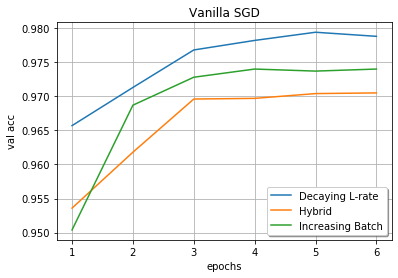

In [42]:
f_vanillasgd, a_vanillasgd = plt.subplots()
a_vanillasgd.plot(range(1,7), exp1_results.history["val_acc"], label="Decaying L-rate")
a_vanillasgd.plot(range(1,7), exp3_results.history["val_acc"], label="Hybrid")
a_vanillasgd.plot(range(1,7), exp2_results.history["val_acc"], label="Increasing Batch")

legend = a_vanillasgd.legend(loc='lower right', shadow=True, fontsize='medium')
a_vanillasgd.set(xlabel='epochs', ylabel='val acc', title='Vanilla SGD')
a_vanillasgd.grid()

f_vanillasgd.savefig("vanilla_sgd.png")

## Experiment 4-6 Plots

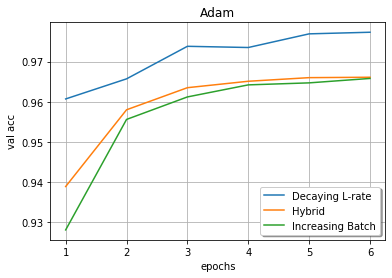

In [43]:
f_adam, a_adam = plt.subplots()
a_adam.plot(range(1,7), exp4_results.history["val_acc"], label="Decaying L-rate")
a_adam.plot(range(1,7), exp6_results.history["val_acc"], label="Hybrid")
a_adam.plot(range(1,7), exp5_results.history["val_acc"], label="Increasing Batch")

legend = a_adam.legend(loc='lower right', shadow=True, fontsize='medium')
a_adam.set(xlabel='epochs', ylabel='val acc', title='Adam')
a_adam.grid()

f_adam.savefig("adam.png")

## Experiment 7-9 Plots

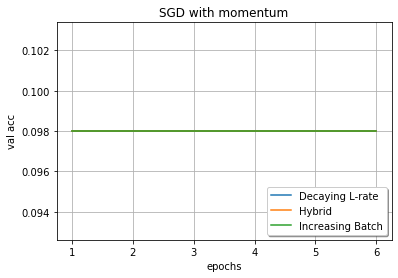

In [44]:
f_sgdm, a_sgdm = plt.subplots()
a_sgdm.plot(range(1,7), exp7_results.history["val_acc"], label="Decaying L-rate")
a_sgdm.plot(range(1,7), exp9_results.history["val_acc"], label="Hybrid")
a_sgdm.plot(range(1,7), exp8_results.history["val_acc"], label="Increasing Batch")

legend = a_sgdm.legend(loc='lower right', shadow=True, fontsize='medium')
a_sgdm.set(xlabel='epochs', ylabel='val acc', title='SGD with momentum')
a_sgdm.grid()

f_sgdm.savefig("sgd_with_momentum.png")